In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import math
from neurodynex. tools import input_factory


WARNING    D:\Programas\Miniconda2\envs\bmnn\lib\site-packages\ipykernel_launcher.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
 [py.warnings]


Missing compiler_cxx fix for MSVCCompiler
nr of spikes: 22303
The Coefficient of Variation (CV) is in percetange of: 264.995197844


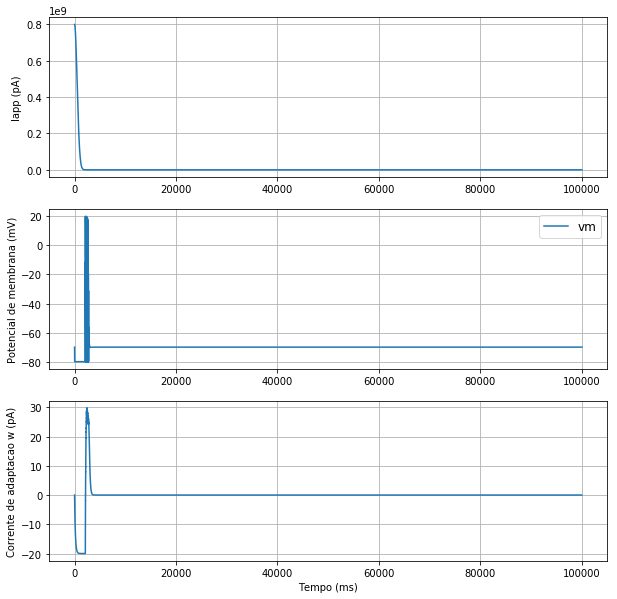

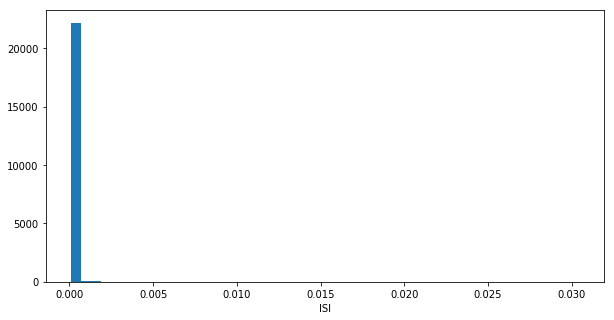

In [74]:
v_rest= -70*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0*b2.nA

tau_w = 150*b2.ms
v_max = 20*b2.mV

simulation_time = 100000
dt =  0.01*b2.ms 

#current = 200.01 * b2.pamp
current = 500*b2.pA
# input_current = input_factory.get_step_current(
# t_start=500, t_end=1000, unit_time=b2.ms,
# amplitude=current*b2.pA) 

append_zero=True
t_start=0
t_end=simulation_time
sigma = 50*b2.pA
dt_cur = 0.01
sigma = sigma/(np.sqrt(dt_cur))
mi=0
unit_time=b2.ms

tmp_size = 1 + t_end  # +1 for t=0
if append_zero:
    tmp_size += 1
tmp = np.zeros((tmp_size/dt_cur, 1)) * b2.pA

x = np.linspace(0, tmp_size, tmp_size/dt_cur) * b2.pA
normal = np.asarray(((1/np.sqrt(2*math.pi*sigma**2))*math.e**(-((x-mi)**2)/(2*sigma**2))))
normal = normal*b2.pA
tmp[t_start: tmp_size/dt_cur + 1, 0] = normal

input_current = b2.TimedArray(tmp, dt=dt)
    
# differential equation of Leaky Integrate-and-Fire model
eqs = """

dv/dt = (conductance_L/membrane_capacitance)*
        (v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current(t,i)/membrane_capacitance) : volt
dw/dt = (a*(v-v_rest)-w)/tau_w :  amp
"""
neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset; w=w+b",
                        threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA

# monitoring membrane potential of neuron and injecting current
state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
spike_monitor = b2.SpikeMonitor(neuron)
# run the simulation
b2.run(simulation_time*b2.ms)

print("nr of spikes: {}".format(spike_monitor.count[0]))
#print("spikes times: {}".format(spike_monitor.t[:]))

#plot
fig = plt.figure(figsize=(10,10))

fig.add_subplot(3,1,1)
c = input_current(state_monitor.t, 0)
plt.plot(state_monitor.t/b2.ms, c/b2.pA)
plt.ylabel('Iapp (pA)')
plt.grid()

fig.add_subplot(3,1,2)
plt.plot(state_monitor.t/b2.ms, state_monitor.v[0]/b2.mV)

plt.ylabel('Potencial de membrana (mV)')
plt.grid()
plt.legend(["vm", "firing threshold"], fontsize=12)

fig.add_subplot(3,1,3)
plt.plot(state_monitor.t/b2.ms, state_monitor.w[0]/b2.pA)
plt.grid()
plt.xlabel('Tempo (ms)')
plt.ylabel('Corrente de adaptacao w (pA)')

plt.show()
# print(spike_monitor.spike_trains([1][1]))
# print(spike_monitor.spike_trains([1][0]))
vector = list()
spikes = spike_monitor.count[:]
inter = np.full(len(spikes[:]), np.nan)

for k in range(len(spike_monitor.t)-1):
    inter = (float(spike_monitor.spike_trains()[0][k+1]) - float(spike_monitor.spike_trains()[0][k]));
    vector.append(inter)
        
fig = plt.figure(figsize=(10, 5))
plt.hist(vector, 50)
plt.xlabel('ISI')


isi_mu = np.mean(vector)
isi_std = np.std(vector)
CV = isi_std*100/isi_mu
print("The Coefficient of Variation (CV) is in percetange of: %s" % CV)


# state_monitor.t[0:100]/b2.ms, state_monitor.v[0][0:100]/b2.mV

    

In [4]:
v_rest= -70*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0*b2.nA

tau_w = 150*b2.ms
v_max = 20*b2.mV

simulation_time = 100000
dt =  0.01*b2.ms 

#current = 200.01 * b2.pamp
current = 500*b2.pA
# input_current = input_factory.get_step_current(
# t_start=500, t_end=1000, unit_time=b2.ms,
# amplitude=current*b2.pA) 

append_zero=True
t_start=0
t_end=simulation_time
sigma = 50*b2.pA
dt_cur = 0.01
sigma = sigma/(np.sqrt(dt_cur))
mi=0
unit_time=b2.ms

tmp_size = 1 + t_end  # +1 for t=0
if append_zero:
    tmp_size += 1
tmp = np.zeros((tmp_size/dt_cur, 1)) * b2.pA

x = np.linspace(0, tmp_size, tmp_size/dt_cur) * b2.pA
normal = np.asarray(((1/np.sqrt(2*math.pi*sigma**2))*math.e**(-((x-mi)**2)/(2*sigma**2))))
normal = normal*b2.pA
tmp[t_start: tmp_size/dt_cur + 1, 0] = normal

input_current = b2.TimedArray(tmp, dt=dt)
    
# differential equation of Leaky Integrate-and-Fire model
eqs = """

dv/dt = (conductance_L/membrane_capacitance)*
        (v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current(t,i)/membrane_capacitance) : volt
dw/dt = (a*(v-v_rest)-w)/tau_w :  amp
"""
neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset; w=w+b",
                        threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA

# monitoring membrane potential of neuron and injecting current

# run the simulation
aux=[]
for j in range(1000):
    state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    b2.run(100*b2.ms)
    aux.append(spike_monitor.count[:])
    
print("ALL FANOs: {}".format(aux))
mean = np.mean(aux)
# print(mean)
var = np.var(aux)
# print(var)
print("FANO: {}".format(var/mean))


WARNING    D:\Programas\Miniconda2\envs\bmnn\lib\site-packages\ipykernel_launcher.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
 [py.warnings]


ALL FANOs: [array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([1000]), array([598]), array([352]), array([200]), array([96]), array([40]), array([14]), array([3]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), arra

WARNING    D:\Programas\Miniconda2\envs\bmnn\lib\site-packages\ipykernel_launcher.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
 [py.warnings]
WARNING    "i" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 99. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


5050.0
8332500.0
FANO: 1650.0


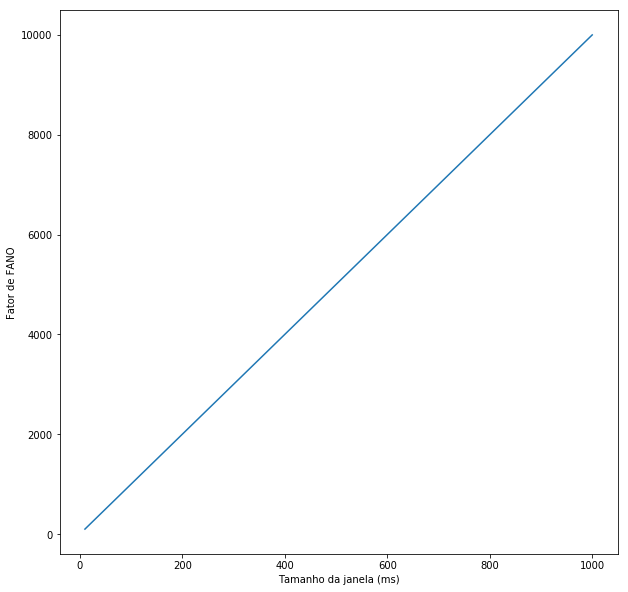

In [3]:
v_rest= -70*b2.mV #EL
v_reset= -80*b2.mV #Vreset
conductance_L = 10*b2.nsiemens #GL
membrane_capacitance = 100*b2.pF #CM
firing_threshold = -50 * b2.mV #Vth
deltaVth = 2*b2.mV

a = 2*b2.nsiemens
b = 0*b2.nA

tau_w = 150*b2.ms
v_max = 20*b2.mV

simulation_time = 1000
dt =  0.01*b2.ms 

#current = 200.01 * b2.pamp
current = 500*b2.pA
# input_current = input_factory.get_step_current(
# t_start=500, t_end=1000, unit_time=b2.ms,
# amplitude=current*b2.pA) 

append_zero=True
t_start=0
t_end=simulation_time
sigma = 50*b2.pA
dt_cur = 0.01
sigma = sigma/(np.sqrt(dt_cur))
mi=0
unit_time=b2.ms

tmp_size = 1 + t_end  # +1 for t=0
if append_zero:
    tmp_size += 1
tmp = np.zeros((tmp_size/dt_cur, 1)) * b2.pA

x = np.linspace(0, t_end+1, tmp_size/dt_cur) * b2.pA
normal = np.asarray(((1/np.sqrt(2*math.pi*sigma**2))*math.e**(-((x-mi)**2)/(2*sigma**2))))
normal = normal*b2.pA  
tmp[t_start: tmp_size/dt_cur + 1, 0] = normal

input_current = b2.TimedArray(tmp, dt=dt)
    

eqs = """

dv/dt = (conductance_L/membrane_capacitance)*
        (v_rest - v + deltaVth*exp((v-firing_threshold)/deltaVth))
        - (w/membrane_capacitance)
        + (input_current(t,i)/membrane_capacitance) : volt
dw/dt = (a*(v-v_rest)-w)/tau_w :  amp
"""
neuron = b2.NeuronGroup(1, model=eqs, reset="v=v_reset; w=w+b",
                        threshold="v>v_max", method="euler")
neuron.v = v_rest
neuron.w = 0*b2.pA

# monitoring membrane potential of neuron and injecting current

# run the simulation
aux=[]
win=[]
for j in range(100):
    state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    win.append(10*(j+1))
    b2.run(10*(j+1)*b2.ms)
    aux.append(spike_monitor.count[:])

#mean = np.mean(aux)
# print(mean)
#var = np.var(aux)
# print(var)
#print("FANO: {}".format(var/mean))

plt.figure(figsize=(10,10))

plt.plot(win, aux)
plt.xlabel('Tamanho da janela (ms)')
plt.ylabel('Fator de FANO')
plt.show()